In [22]:
import argparse
from collections import namedtuple
import sys
import numpy as np
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import pickle

In [23]:
# Set parameters directly in the script
data_path = 'historical_data.csv'
rate_normal_train = 0.82
test_rep_count = 10
TRAIN_RAND_SEED = 42
TEST_RAND_SEED = [42, 89, 2, 156, 491, 32, 67, 341, 100, 279]
rate_anomaly_test = 0.1  # Define rate_anomaly_test here

# Create an instance of RandomState for shuffling
TRAIN_DATA_RNG = np.random.RandomState(TRAIN_RAND_SEED)

In [24]:
def load_data(data_path):
    data = pd.read_csv(data_path)
    try:
        datetime_col = data['Timestamp']
        sbp_col = data['SBP']
        dbp_col = data['DBP']
        features = np.column_stack((sbp_col, dbp_col))
    except KeyError as e:
        print(f'Missing required column: {e}')
        sys.exit(1)
    return features, datetime_col

In [25]:
def categorize_blood_pressure(sbp, dbp):
    if sbp > 180 or dbp > 120:
        return "Hypertensive Crisis"
    elif sbp >= 140 or dbp >= 90:
        return "Hypertension Stage 2"
    elif sbp == 0 or dbp == 0:
        return "Dead"
    elif sbp >= 130 or dbp >= 80:
        return "Hypertension Stage 1"
    elif 120 <= sbp <= 129 and dbp < 80:
        return "Elevated"
    elif sbp < 120 and dbp < 80:
        return "Normal"
    else:
        return "Uncategorized"

In [26]:
def prepare_data(features, datetime_col, rate_normal_train):
    labels = [categorize_blood_pressure(sbp, dbp) for sbp, dbp in features]
    binary_labels = np.array([1 if label != "Normal" else 0 for label in labels])
    inds = TRAIN_DATA_RNG.permutation(features.shape[0])
    features_data = features[inds]
    labels_data = binary_labels[inds]
    index = int(features.shape[0] * rate_normal_train)
    trainx = features_data[:index]
    testx_n = features_data[index:]
    testy_n = labels_data[index:]
    split_data = namedtuple('split_data', ('train_x', 'testx_n', 'testy_n'))
    return split_data(train_x=trainx, testx_n=testx_n, testy_n=testy_n)

In [27]:
def make_test_data(split_data, RNG, rate_anomaly_test):
    testx_n = split_data.testx_n
    testy_n = split_data.testy_n
    inds_1 = RNG.permutation(testx_n.shape[0])
    testx_a = testx_n[inds_1]
    testy_a = testy_n[inds_1]
    testx = np.concatenate([testx_a, testx_n], axis=0)
    testy = np.concatenate([testy_a, testy_n], axis=0)
    return testx, testy

In [28]:
def calc_metrics(testy, scores):
    precision, recall, _ = precision_recall_curve(testy, scores)
    roc_auc = roc_auc_score(testy, scores)
    prc_auc = auc(recall, precision)
    return roc_auc, prc_auc

In [29]:
def plot_pr_roc_curve(precision, recall, pr_auc, fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [30]:
def plot_anomaly_detection(features, labels, clf):
    plt.figure(figsize=(8, 6))
    scores = clf.decision_function(features).ravel() * (-1)
    plt.scatter(features[:, 0], features[:, 1], c=scores, cmap='viridis', label='Anomaly Score')
    plt.colorbar(label='Anomaly Score')
    plt.title('Anomaly Detection in Feature Space')
    plt.xlabel('SBP')
    plt.ylabel('DBP')
    plt.legend()
    plt.show()

--- nu :  0.1  ---
PR AUC :  0.21199847854973713
ROC_AUC :  0.8590279253121826


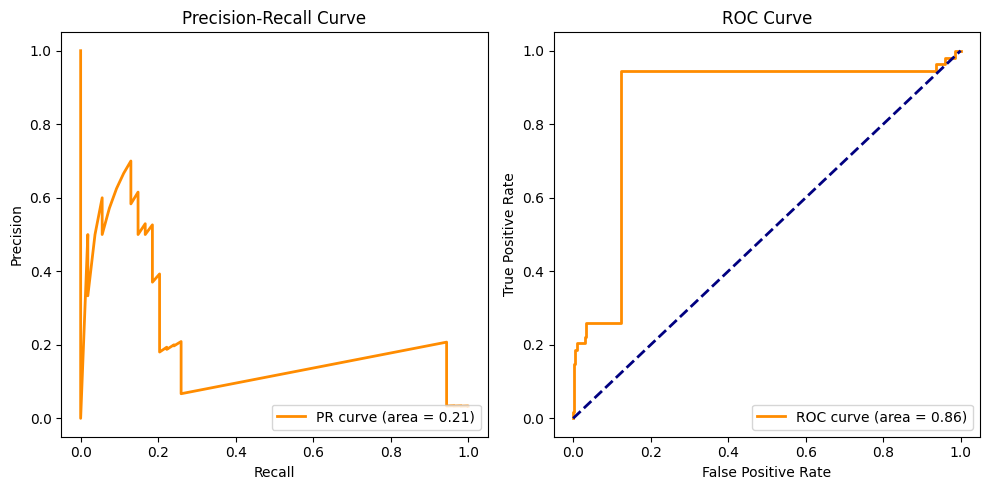

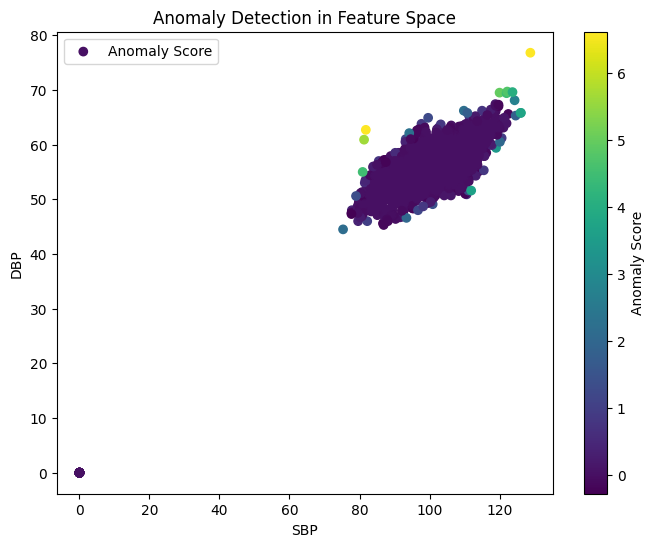

Model saved
--- nu :  0.2  ---
PR AUC :  0.18804279483156372
ROC_AUC :  0.8044874064631868


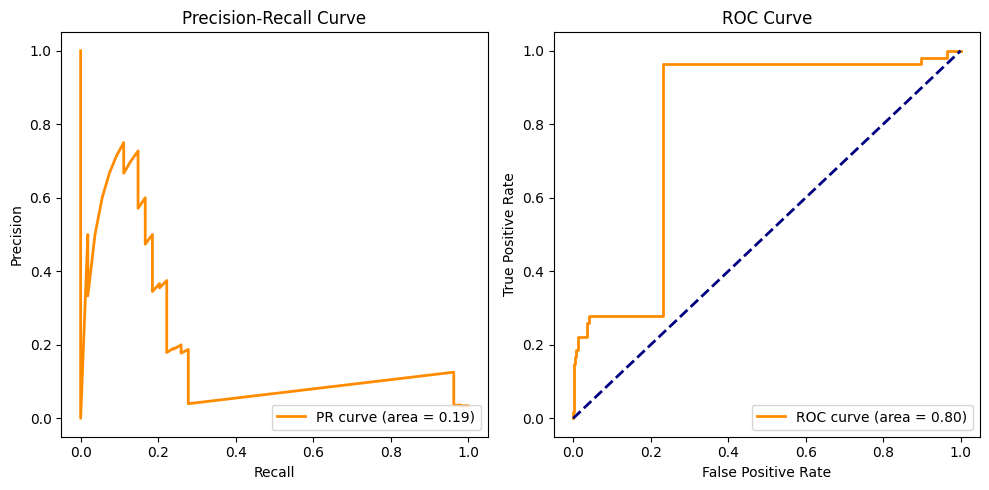

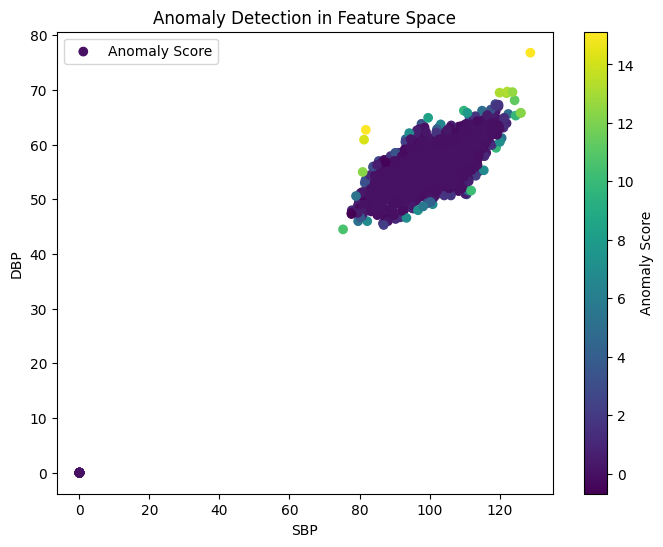

Model saved
--- nu :  0.3  ---
PR AUC :  0.18904121571310475
ROC_AUC :  0.8038854660906922


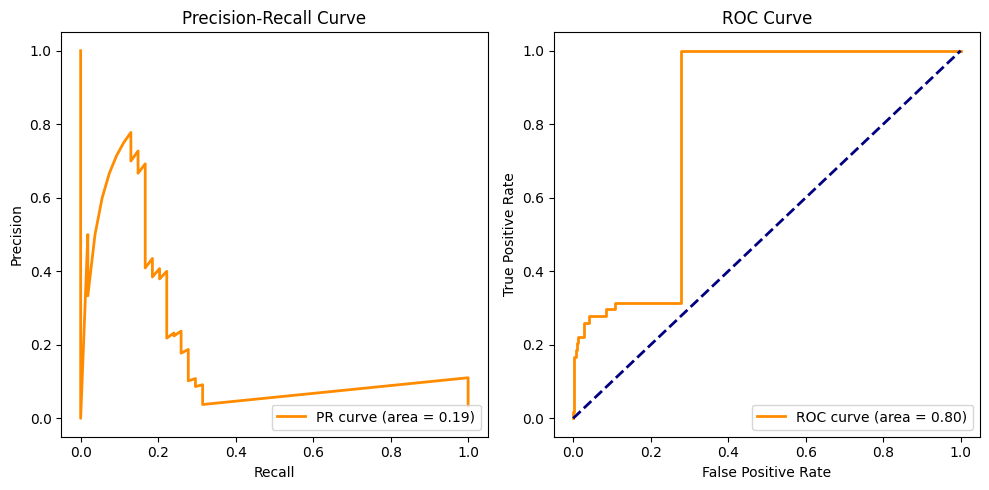

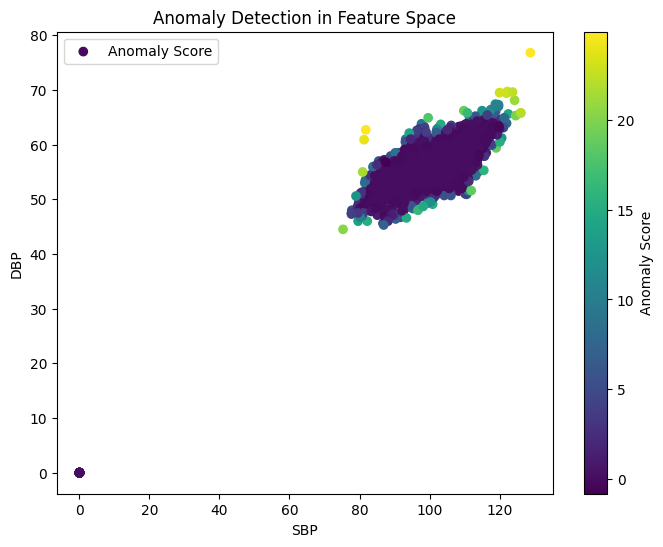

Model saved
--- nu :  0.4  ---
PR AUC :  0.17258307185076058
ROC_AUC :  0.709250997332578


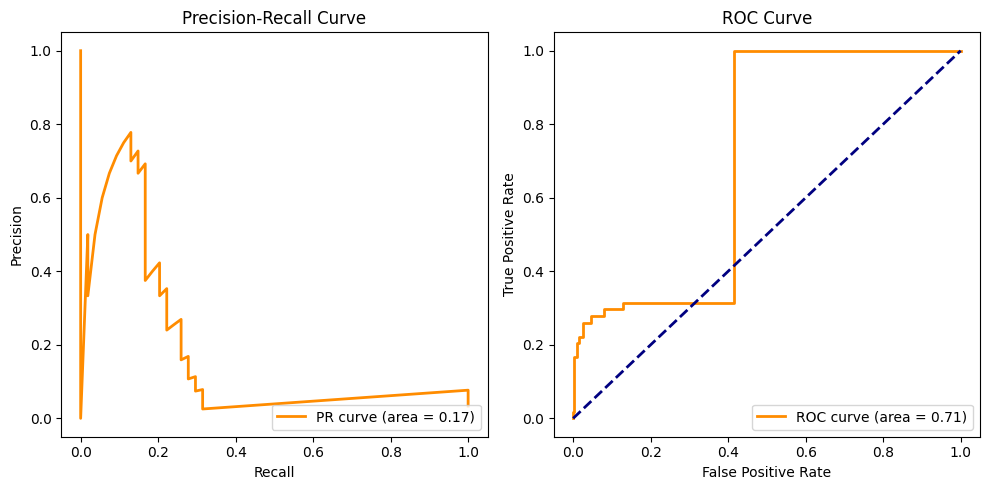

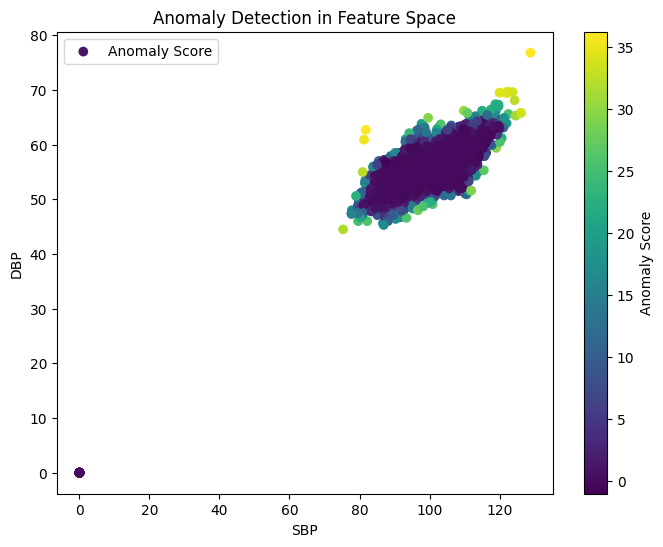

Model saved
--- nu :  0.5  ---
PR AUC :  0.16970306764780904
ROC_AUC :  0.6695937492623278


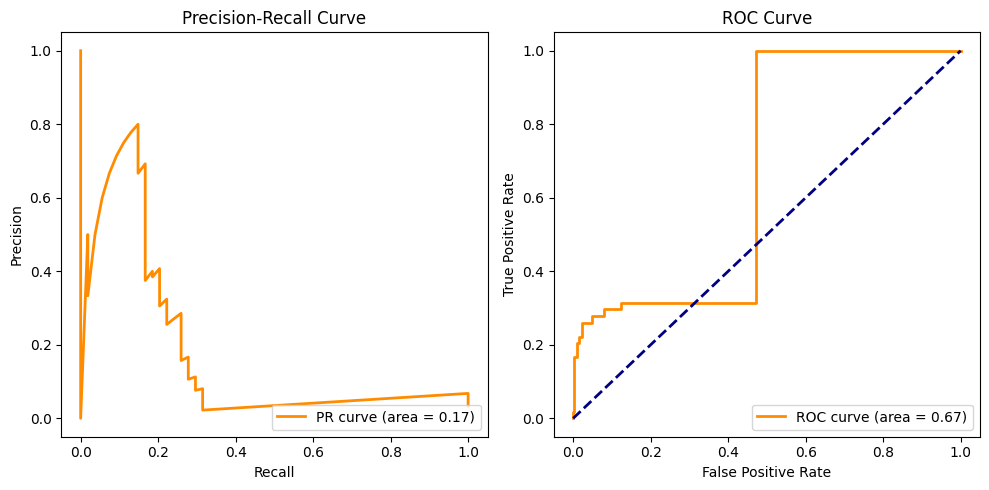

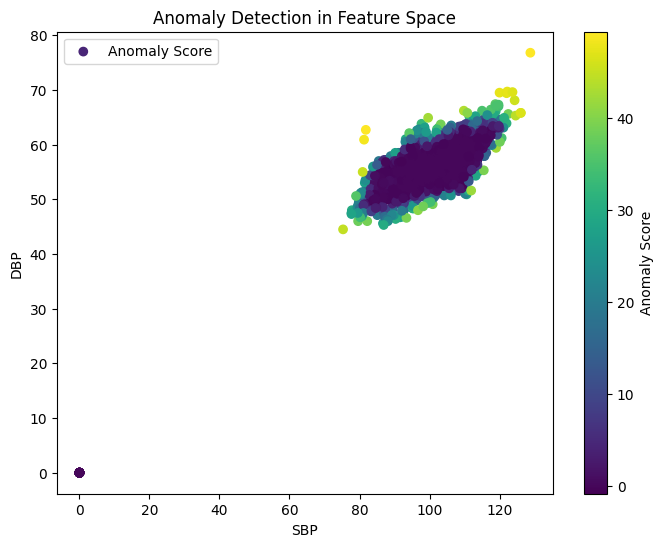

Model saved
***************
PR_AUC MAX :  0.21199847854973713
ROC_AUC MAX :  0.8590279253121826
ROC_MAX_NU :  0.1


In [31]:
def main():
    full_images, datetime_col = load_data(data_path)
    split_data = prepare_data(full_images, datetime_col, rate_normal_train)

    pr_scores = []
    roc_scores = []

    # nu : the upper limit ratio of anomaly data(0<=nu<=1)
    nus = [0.1, 0.2, 0.3,0.4,0.5]

    # train model and evaluate with changing parameter nu
    for nu in nus:
        # train with nu
        clf = svm.OneClassSVM(nu=nu, kernel='rbf', gamma='auto')
        clf.fit(split_data.train_x)

        total_pr = 0
        total_roc = 0

        # repeat test by randomly selected data and evaluate
        for j in range(test_rep_count):
            # select test data and test
            if j < len(TEST_RAND_SEED):
                TEST_SEED = np.random.RandomState(TEST_RAND_SEED[j])
            else:
                TEST_SEED = np.random.RandomState(np.random.randint(0, 10000))

            testx, testy = make_test_data(split_data, TEST_SEED, rate_anomaly_test)
            scores = clf.decision_function(testx).ravel() * (-1)

            # calculate evaluation metrics
            roc_auc, prc_auc = calc_metrics(testy, scores)

            total_pr += prc_auc
            total_roc += roc_auc

        # calculate average
        total_pr /= test_rep_count
        total_roc /= test_rep_count

        pr_scores.append(total_pr)
        roc_scores.append(total_roc)

        print('--- nu : ', nu, ' ---')
        print('PR AUC : ', total_pr)
        print('ROC_AUC : ', total_roc)

        # Plot Precision-Recall and ROC curves
        precision, recall, _ = precision_recall_curve(testy, scores)
        fpr, tpr, _ = roc_curve(testy, scores)
        plot_pr_roc_curve(precision, recall, total_pr, fpr, tpr, total_roc)

        # Plot points in the feature space with anomaly scores
        plot_anomaly_detection(split_data.testx_n, split_data.testy_n, clf)

        # Save the model using pickle
        with open('OC_SVM.pkl', 'wb') as model_file:
            pickle.dump(clf, model_file)
        print('Model saved')

    print('***' * 5)
    print('PR_AUC MAX : ', max(pr_scores))
    print('ROC_AUC MAX : ', max(roc_scores))
    print('ROC_MAX_NU : ', nus[int(np.argmax(roc_scores))])

if __name__ == '__main__':
    main()
